In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize":[12,10]},font_scale=1.5)
pd.set_option("display.max_columns",None)

from datasist.structdata import detect_outliers
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
outlier_df=pd.read_csv("D:\project\outlier_df")
outlier_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21643 entries, 0 to 21642
Data columns (total 67 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   totalMandates                      21643 non-null  int64  
 1   availableMandates                  21643 non-null  int64  
 2   numParishes                        21643 non-null  int64  
 3   numParishesApproved                21643 non-null  int64  
 4   blankVotes                         21643 non-null  int64  
 5   nullVotes                          21643 non-null  int64  
 6   subscribedVoters                   21643 non-null  int64  
 7   totalVoters                        21643 non-null  int64  
 8   pre.blankVotes                     21643 non-null  int64  
 9   pre.nullVotes                      21643 non-null  int64  
 10  pre.subscribedVoters               21643 non-null  int64  
 11  pre.totalVoters                    21643 non-null  int

In [3]:
outlier_df.duplicated().sum()

0

In [4]:
outlier_df.drop_duplicates(inplace=True)

In [5]:
outlier_df.isna().mean()

totalMandates          0.0
availableMandates      0.0
numParishes            0.0
numParishesApproved    0.0
blankVotes             0.0
                      ... 
Party_PS               0.0
Party_PTP              0.0
Party_PURP             0.0
Party_R.I.R.           0.0
day_name_Sunday        0.0
Length: 67, dtype: float64

In [6]:
outlier_df.drop(columns=["totalMandates","availableMandates"],inplace=True)

In [7]:
outlier_df.isna().sum()

numParishes            0
numParishesApproved    0
blankVotes             0
nullVotes              0
subscribedVoters       0
                      ..
Party_PS               0
Party_PTP              0
Party_PURP             0
Party_R.I.R.           0
day_name_Sunday        0
Length: 65, dtype: int64

In [8]:
outlier_df["FinalMandates"].describe()

count    21643.000000
mean         1.126138
std          6.872644
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        106.000000
Name: FinalMandates, dtype: float64

In [9]:
outliers_copy=outlier_df.copy()

In [10]:
outliers_copy.isna().mean().index

Index(['numParishes', 'numParishesApproved', 'blankVotes', 'nullVotes',
       'subscribedVoters', 'totalVoters', 'pre.blankVotes', 'pre.nullVotes',
       'pre.subscribedVoters', 'pre.totalVoters', 'Mandates', 'Percentage',
       'validVotesPercentage', 'Votes', 'Hondt', 'FinalMandates', 'year',
       'month', 'day', 'hour', 'minutes', 'second', 'actual_votes_currently',
       'last_actual_votes', 'territoryName_Açores', 'territoryName_Beja',
       'territoryName_Braga', 'territoryName_Bragança',
       'territoryName_Castelo Branco', 'territoryName_Coimbra',
       'territoryName_Faro', 'territoryName_Guarda', 'territoryName_Leiria',
       'territoryName_Lisboa', 'territoryName_Madeira',
       'territoryName_Portalegre', 'territoryName_Porto',
       'territoryName_Santarém', 'territoryName_Setúbal',
       'territoryName_Território Nacional', 'territoryName_Viana do Castelo',
       'territoryName_Vila Real', 'territoryName_Viseu', 'territoryName_Évora',
       'Party_B.E.', '

-Impute nan values in numerical colunms

In [11]:
numerical_col=['numParishes', 'numParishesApproved', 'blankVotes', 'nullVotes',
       'subscribedVoters', 'totalVoters', 'pre.blankVotes', 'pre.nullVotes',
       'pre.subscribedVoters', 'pre.totalVoters', 'Votes']

In [12]:
categorical_col=['territoryName_Açores',
       'territoryName_Beja', 'territoryName_Braga', 'territoryName_Bragança',
       'territoryName_Castelo Branco', 'territoryName_Coimbra',
       'territoryName_Faro', 'territoryName_Guarda', 'territoryName_Leiria',
       'territoryName_Lisboa', 'territoryName_Madeira',
       'territoryName_Portalegre', 'territoryName_Porto',
       'territoryName_Santarém', 'territoryName_Setúbal',
       'territoryName_Território Nacional', 'territoryName_Viana do Castelo',
       'territoryName_Vila Real', 'territoryName_Viseu', 'territoryName_Évora',
       'Party_B.E.', 'Party_CDS-PP', 'Party_CH', 'Party_IL', 'Party_JPP',
       'Party_L', 'Party_MAS', 'Party_MPT', 'Party_NC', 'Party_PAN',
       'Party_PCP-PEV', 'Party_PCTP/MRPP', 'Party_PDR', 'Party_PNR',
       'Party_PPD/PSD', 'Party_PPM', 'Party_PS', 'Party_PTP', 'Party_PURP',
       'Party_R.I.R.', 'day_name_Sunday']

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x=outliers_copy.drop(columns=["FinalMandates"])
y=outliers_copy["FinalMandates"]

In [17]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

-First impute x_train , y_train

In [18]:
from sklearn.impute import SimpleImputer

- Columns must be same length as key , so i should drop "second " columns which contains 0

In [19]:
x_train.drop(columns=["second"],inplace=True)

-imputed x_train["numerical_col] by simple imputer , then should be imputed x_train [Categorical_col]

In [20]:
imputer=SimpleImputer(strategy="most_frequent")
x_train[numerical_col]=imputer.fit_transform(x_train[numerical_col])

In [21]:
x_train[numerical_col].isna().sum()

numParishes             0
numParishesApproved     0
blankVotes              0
nullVotes               0
subscribedVoters        0
totalVoters             0
pre.blankVotes          0
pre.nullVotes           0
pre.subscribedVoters    0
pre.totalVoters         0
Votes                   0
dtype: int64

-Check for nan values in x_train

In [22]:
x_train[numerical_col].isna().sum()

numParishes             0
numParishesApproved     0
blankVotes              0
nullVotes               0
subscribedVoters        0
totalVoters             0
pre.blankVotes          0
pre.nullVotes           0
pre.subscribedVoters    0
pre.totalVoters         0
Votes                   0
dtype: int64

In [23]:
imputer_cate=SimpleImputer(strategy="most_frequent")
x_train[categorical_col]=imputer_cate.fit_transform(x_train[categorical_col])

-now i gotten rid of nan values in x_train (numerical-categorical)

In [24]:
x_train[categorical_col].isna().sum()

territoryName_Açores                 0
territoryName_Beja                   0
territoryName_Braga                  0
territoryName_Bragança               0
territoryName_Castelo Branco         0
territoryName_Coimbra                0
territoryName_Faro                   0
territoryName_Guarda                 0
territoryName_Leiria                 0
territoryName_Lisboa                 0
territoryName_Madeira                0
territoryName_Portalegre             0
territoryName_Porto                  0
territoryName_Santarém               0
territoryName_Setúbal                0
territoryName_Território Nacional    0
territoryName_Viana do Castelo       0
territoryName_Vila Real              0
territoryName_Viseu                  0
territoryName_Évora                  0
Party_B.E.                           0
Party_CDS-PP                         0
Party_CH                             0
Party_IL                             0
Party_JPP                            0
Party_L                  

-should be handled zeros values in colunms

- First : x_train [numerical_col]\
    -x_train [numerical_col] : [Mandates ,Hondt ,hour ,minutes] that cotain almost 100 % zero values so should be dropped it

In [25]:
x_train[numerical_col].isin([0.0,0]).mean()

numParishes             0.0
numParishesApproved     0.0
blankVotes              0.0
nullVotes               0.0
subscribedVoters        0.0
totalVoters             0.0
pre.blankVotes          0.0
pre.nullVotes           0.0
pre.subscribedVoters    0.0
pre.totalVoters         0.0
Votes                   0.0
dtype: float64

- should be droped this columns because ["Mandates" ,"Hondt" ,"hour" ,"minutes"] columns = 0

In [26]:
x_train.drop(columns=["Mandates" ,"Hondt" ,"hour" ,"minutes"],inplace=True)

In [27]:
x_train.drop("year",axis=1,inplace=True)

- Second: X_train [categorical_col]

In [28]:
x_train[categorical_col].isin([0.0,0]).mean()

territoryName_Açores                 0.963282
territoryName_Beja                   0.959524
territoryName_Braga                  0.946279
territoryName_Bragança               0.954473
territoryName_Castelo Branco         0.954041
territoryName_Coimbra                0.951516
territoryName_Faro                   0.952255
territoryName_Guarda                 0.953857
territoryName_Leiria                 0.946156
territoryName_Lisboa                 0.951146
territoryName_Madeira                0.949791
territoryName_Portalegre             0.957738
territoryName_Porto                  0.948558
territoryName_Santarém               0.952070
territoryName_Setúbal                0.950345
territoryName_Território Nacional    0.948435
territoryName_Viana do Castelo       0.949852
territoryName_Vila Real              0.959709
territoryName_Viseu                  0.949174
territoryName_Évora                  0.952316
Party_B.E.                           0.947881
Party_CDS-PP                      

-i saw that all columns in x_train [ categorical columns] = 0 ,so i should drop it 

In [29]:
x_train[categorical_col].columns

Index(['territoryName_Açores', 'territoryName_Beja', 'territoryName_Braga',
       'territoryName_Bragança', 'territoryName_Castelo Branco',
       'territoryName_Coimbra', 'territoryName_Faro', 'territoryName_Guarda',
       'territoryName_Leiria', 'territoryName_Lisboa', 'territoryName_Madeira',
       'territoryName_Portalegre', 'territoryName_Porto',
       'territoryName_Santarém', 'territoryName_Setúbal',
       'territoryName_Território Nacional', 'territoryName_Viana do Castelo',
       'territoryName_Vila Real', 'territoryName_Viseu', 'territoryName_Évora',
       'Party_B.E.', 'Party_CDS-PP', 'Party_CH', 'Party_IL', 'Party_JPP',
       'Party_L', 'Party_MAS', 'Party_MPT', 'Party_NC', 'Party_PAN',
       'Party_PCP-PEV', 'Party_PCTP/MRPP', 'Party_PDR', 'Party_PNR',
       'Party_PPD/PSD', 'Party_PPM', 'Party_PS', 'Party_PTP', 'Party_PURP',
       'Party_R.I.R.', 'day_name_Sunday'],
      dtype='object')

- Scaling x_train and transform it x_test \
    -I used to Robust scaler because it's equation based on median so doesn't effect with outliers in dataset

In [31]:
from sklearn.preprocessing import RobustScaler

In [32]:
scaler=RobustScaler()
scaler.fit(x_train[numerical_col])
x_train[numerical_col]=scaler.transform(x_train[numerical_col])

- impute y_train

-impute y_train with median and then handle it

In [33]:
y_train=np.where (y_train.isna(),y_train.median(),y_train)

In [34]:
y_train=pd.Series(y_train)
y_train.value_counts()

0.0      13375
1.0        852
2.0        521
3.0        482
4.0        280
5.0        203
8.0         82
12.0        78
19.0        45
6.0         44
17.0        42
9.0         41
7.0         40
77.0        39
20.0        38
106.0       36
15.0        34
dtype: int64

c:\ProgramData\Anaonda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

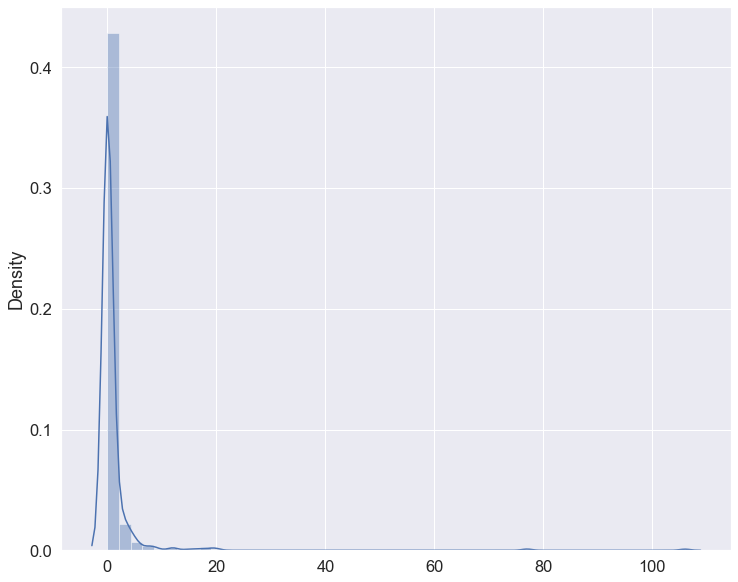

In [35]:
sns.distplot(y_train)

- apply all steps performed x_train columns on x_test columns to prevent leakage

In [36]:
y_test=pd.Series(y_test)


In [37]:
y_test=np.where (y_test.isna(),y_test.median(),y_test)

In [38]:
x_test.drop(columns=["second"],inplace=True)

In [39]:
x_test.drop(columns=["Mandates" ,"Hondt" ,"hour" ,"minutes"],inplace=True)

In [40]:
x_test.drop("year",axis=1,inplace=True)

- apply x_train imputer on x_test dataset (numerical - categorical)

In [41]:
x_test[numerical_col]=imputer.transform(x_test[numerical_col])

In [42]:
x_test[numerical_col].isna().sum()

numParishes             0
numParishesApproved     0
blankVotes              0
nullVotes               0
subscribedVoters        0
totalVoters             0
pre.blankVotes          0
pre.nullVotes           0
pre.subscribedVoters    0
pre.totalVoters         0
Votes                   0
dtype: int64

- x_train imputer for categorical data and transform it on x_test categorical dataset

In [89]:
imputer_cate=SimpleImputer(strategy="most_frequent")
x_train[categorical_col]=imputer_cate.fit_transform(x_train[categorical_col])

KeyError: "None of [Index(['territoryName_Açores', 'territoryName_Beja', 'territoryName_Braga',\n       'territoryName_Bragança', 'territoryName_Castelo Branco',\n       'territoryName_Coimbra', 'territoryName_Faro', 'territoryName_Guarda',\n       'territoryName_Leiria', 'territoryName_Lisboa', 'territoryName_Madeira',\n       'territoryName_Portalegre', 'territoryName_Porto',\n       'territoryName_Santarém', 'territoryName_Setúbal',\n       'territoryName_Território Nacional', 'territoryName_Viana do Castelo',\n       'territoryName_Vila Real', 'territoryName_Viseu', 'territoryName_Évora',\n       'Party_B.E.', 'Party_CDS-PP', 'Party_CH', 'Party_IL', 'Party_JPP',\n       'Party_L', 'Party_MAS', 'Party_MPT', 'Party_NC', 'Party_PAN',\n       'Party_PCP-PEV', 'Party_PCTP/MRPP', 'Party_PDR', 'Party_PNR',\n       'Party_PPD/PSD', 'Party_PPM', 'Party_PS', 'Party_PTP', 'Party_PURP',\n       'Party_R.I.R.', 'day_name_Sunday'],\n      dtype='object')] are in the [columns]"

In [44]:
y_train=pd.DataFrame(y_train,columns=["final_mandates"])

- apply imputer on x_test without fitting to prevent leakage

In [45]:
x_test[categorical_col]=imputer_cate.transform(x_test[categorical_col])

In [46]:
x_test[categorical_col].isna().sum()

territoryName_Açores                 0
territoryName_Beja                   0
territoryName_Braga                  0
territoryName_Bragança               0
territoryName_Castelo Branco         0
territoryName_Coimbra                0
territoryName_Faro                   0
territoryName_Guarda                 0
territoryName_Leiria                 0
territoryName_Lisboa                 0
territoryName_Madeira                0
territoryName_Portalegre             0
territoryName_Porto                  0
territoryName_Santarém               0
territoryName_Setúbal                0
territoryName_Território Nacional    0
territoryName_Viana do Castelo       0
territoryName_Vila Real              0
territoryName_Viseu                  0
territoryName_Évora                  0
Party_B.E.                           0
Party_CDS-PP                         0
Party_CH                             0
Party_IL                             0
Party_JPP                            0
Party_L                  

In [47]:
y_test=pd.DataFrame(y_test,columns=["final_mandates"])

- Scaling x_test by transformed train equation

In [48]:

x_test[numerical_col]=scaler.transform(x_test[numerical_col])

In [49]:
x_train[categorical_col].columns

Index(['territoryName_Açores', 'territoryName_Beja', 'territoryName_Braga',
       'territoryName_Bragança', 'territoryName_Castelo Branco',
       'territoryName_Coimbra', 'territoryName_Faro', 'territoryName_Guarda',
       'territoryName_Leiria', 'territoryName_Lisboa', 'territoryName_Madeira',
       'territoryName_Portalegre', 'territoryName_Porto',
       'territoryName_Santarém', 'territoryName_Setúbal',
       'territoryName_Território Nacional', 'territoryName_Viana do Castelo',
       'territoryName_Vila Real', 'territoryName_Viseu', 'territoryName_Évora',
       'Party_B.E.', 'Party_CDS-PP', 'Party_CH', 'Party_IL', 'Party_JPP',
       'Party_L', 'Party_MAS', 'Party_MPT', 'Party_NC', 'Party_PAN',
       'Party_PCP-PEV', 'Party_PCTP/MRPP', 'Party_PDR', 'Party_PNR',
       'Party_PPD/PSD', 'Party_PPM', 'Party_PS', 'Party_PTP', 'Party_PURP',
       'Party_R.I.R.', 'day_name_Sunday'],
      dtype='object')

In [50]:
x_train.drop(columns=x_train[categorical_col].columns,inplace=True)

In [51]:
x_test.drop(columns=x_test[categorical_col].columns,inplace=True)

In [52]:
dic_regressor_1_={"linear":LinearRegression(),"Knn":KNeighborsRegressor(),"xgboost":XGBRegressor(),"random_forest":RandomForestRegressor(),"svr":SVR(),"decision_tree":DecisionTreeRegressor()}

In [53]:
x_train.shape,x_test.shape

((16232, 17), (5411, 17))

In [54]:
y_train.shape

(16232, 1)

In [55]:
x_train

,numParishes,numParishesApproved,blankVotes,nullVotes,subscribedVoters,totalVoters,pre.blankVotes,pre.nullVotes,pre.subscribedVoters,pre.totalVoters,Percentage,validVotesPercentage,Votes,month,day,actual_votes_currently,last_actual_votes
17034,-0.221557,-0.070922,0.912822,0.974633,0.722383,0.817993,0.897479,0.899754,0.738702,0.811262,0.17,0.18,-0.092955,10,6,428323,435402
8522,-0.479042,-0.397163,0.237678,0.159546,0.391080,0.317726,0.245676,0.193458,0.366787,0.360852,0.96,1.01,0.158199,10,6,336721,331936
9169,17.634731,19.858156,15.582179,20.660547,23.868285,22.874694,15.647843,20.649314,23.744489,22.242638,0.16,0.17,1.121894,10,6,6531048,6644791
7315,-0.479042,-0.404255,0.221365,0.137183,0.362300,0.292505,0.231298,0.172353,0.339815,0.335437,0.81,0.85,0.099503,10,6,329150,324676
3537,0.053892,-0.517730,-0.398351,-0.681909,-0.747804,-0.637982,-0.420088,-0.656349,-0.726814,-0.597825,0.59,0.63,-0.163110,10,6,37309,37190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,0.778443,1.113475,0.349588,0.491322,0.462532,0.500073,0.341738,0.524446,0.542513,0.509185,0.20,0.21,-0.098802,10,6,356752,379798
21575,-0.550898,-0.460993,0.910893,1.270360,1.971748,2.007758,0.972286,1.421738,1.881901,1.982751,1.05,1.08,0.784683,10,7,750912,739493
5390,-0.467066,-0.432624,-0.393966,-0.522363,-0.633560,-0.492232,-0.387164,-0.549420,-0.602119,-0.443270,45.42,47.37,3.487518,10,6,67230,70620
860,0.473054,-0.170213,-0.478863,-0.637183,-0.761773,-0.634211,-0.485518,-0.640169,-0.729330,-0.595882,0.38,0.39,-0.169424,10,6,33387,36257


In [56]:
for name_1,model_1 in dic_regressor_1_.items():
    model_1.fit(x_train,y_train)
    prediction1=model_1.predict(x_test)
    predict_train1=model_1.predict(x_train)

    print(f"name :{name_1}")
    print(f"accuracy :{r2_score(y_test,prediction1)}")
    print(f"accuracy train:{r2_score(y_train,predict_train1)}")
    print ("_"*20)

name :linear
accuracy :0.815304165334085
accuracy train:0.8181069214106916
____________________
name :Knn
accuracy :0.48479111353879056
accuracy train:0.7905005943206141
____________________
name :xgboost
accuracy :0.9680725567692468
accuracy train:0.999962009086134
____________________


C:\Users\Noureen\AppData\Local\Temp\ipykernel_8004\1890307064.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_1.fit(x_train,y_train)


name :random_forest
accuracy :0.9528408320354805
accuracy train:0.9982882475565066
____________________


c:\ProgramData\Anaonda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


name :svr
accuracy :-0.022567094508797014
accuracy train:-0.022314444243310305
____________________
name :decision_tree
accuracy :0.9641803691434825
accuracy train:0.9999961477469261
____________________


#### Optimization for some models 

In [60]:
outlier_copy_df=pd.DataFrame(outliers_copy.columns)

I have used  GRIDSEARCH CROSS VALIDATION with XGBREGRESSOR to determine the best paramerters and recover the overfitting

In [72]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

In [73]:
mode19=XGBRegressor(seed=100)
gri_search=GridSearchCV(mode19,param_grid=params,scoring='neg_mean_squared_error')
gri_search.fit(x_train,y_train)
print(f" the best parameters {gri_search.best_params_}")
print(f"the lowest rmse{gri_search.best_score_}")

 the best parameters {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
the lowest rmse-0.18381024928554046


In [94]:
model7=XGBRegressor(colsample_bytree= 0.3, learning_rate= 0.1, max_depth= 3, n_estimators= 1000)
model7.fit(x_train,y_train)
predict7=model7.predict(x_test)
train_predic7=model7.predict(x_train)
print(f" test :{r2_score(y_test,predict7)}")
print(f" train :{r2_score(y_train,train_predic7)}")

 test :0.9891034524182818
 train :0.9991241725510928


-I used  RandomizedSearch CV with RANDONFORESTREGRESSOR to fit on data , I created Grid cv to choose the best parameters for model

In [79]:
n_estimator=[int(i) for i in np.linspace(200,2000,10)]
max_features=['auto', 'sqrt']
max_depth=[int(i) for i in  np.linspace(10,100,10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


In [80]:
rendomized_grid={"n_estimators":n_estimator,
"max_features":max_features,
"max_depth":max_depth,
"min_samples_split":min_samples_split,
"min_samples_leaf":min_samples_leaf,
"bootstrap":bootstrap}

In [81]:
model12=RandomForestRegressor()
randomized_valid=RandomizedSearchCV(estimator=model12,param_distributions=rendomized_grid,n_iter=50,cv=3,random_state=42,n_jobs = -1)
randomized_valid.fit(x_train,y_train)

c:\ProgramData\Anaonda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

- I created evaluate function to calculate percentage of model's errors and accuracy for both (train , test )

In [82]:
def evaluate(model,x_test,y_test):
    prediction=model.predict(x_test)
    errors=abs(prediction-y_test)
    percent_error=100*np.mean(errors/y_test)
    accuracy=r2_score(y_test,prediction)
    predicted_train=model.predict(x_train)
    accuracy_train=r2_score(y_train,predicted_train)

    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print(f"accuracy : {accuracy}")
    print(f"accuracy_train : {accuracy_train}")




- the best parameters for model

In [83]:
randomized_valid.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [100]:
model_random_for=RandomForestRegressor(n_estimators=1200,min_samples_split=2,min_samples_leaf=1,max_features="sqrt",max_depth=100,bootstrap=False,random_state=42)
model_random_for.fit(x_train,y_train)
random_prediction=model_random_for.predict(x_test)
train_prediction=model_random_for.predict(x_train)
print(f" test :{r2_score(y_test,random_prediction)}")
print(f" train :{r2_score(y_train,train_prediction)}")

C:\Users\Noureen\AppData\Local\Temp\ipykernel_8004\3698559740.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_random_for.fit(x_train,y_train)


 test :0.9934879823320084
 train :0.9999961477469261


-I used the last parameters as a best but generated overfitting

In [139]:
model13=RandomForestRegressor(n_estimators=1000,min_samples_split= 4,
 min_samples_leaf=4,
 max_features= 'sqrt',
 max_depth=95,
 bootstrap= False, max_leaf_nodes=5)

In [140]:
model13.fit(x_train,y_train)

C:\Users\Noureen\AppData\Local\Temp\ipykernel_8004\997364345.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model13.fit(x_train,y_train)


RandomForestRegressor(bootstrap=False, max_depth=95, max_features='sqrt',
                      max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=1000)

In [141]:
y_test
y=np.array(y_test)

In [142]:
evaluate(model13,x_test,y)

C:\Users\Noureen\AppData\Local\Temp\ipykernel_8004\1161862310.py:4: RuntimeWarning: divide by zero encountered in true_divide
  percent_error=100*np.mean(errors/y_test)


Model Performance
Average Error: 2.2231 degrees.
accuracy : 0.9116847530341692
accuracy_train : 0.9131921725909672


In [134]:
model14=RandomForestRegressor(random_state=42,max_depth=50)
model14.fit(x_train,y_train)
predict14=model14.predict(x_test)
predict_train14=model14.predict(x_train)

evaluate(model14,x_test,y)

C:\Users\Noureen\AppData\Local\Temp\ipykernel_8004\3537665411.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model14.fit(x_train,y_train)
C:\Users\Noureen\AppData\Local\Temp\ipykernel_8004\1161862310.py:4: RuntimeWarning: divide by zero encountered in true_divide
  percent_error=100*np.mean(errors/y_test)
C:\Users\Noureen\AppData\Local\Temp\ipykernel_8004\1161862310.py:4: RuntimeWarning: invalid value encountered in true_divide
  percent_error=100*np.mean(errors/y_test)


Model Performance
Average Error: 2.2875 degrees.
accuracy : 0.9559959482001991
accuracy_train : 0.9989690911538234
